# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, I will use the tools you learned about in the lesson to identify lane lines on the road in some images and videos. The project is divided on 6 main tasks:

* **Task 1**. Develop a first version of the pipeline (function `lane_line_detection` and `param` dictionary)
* **Task 2**. Applies it to individual images located on the folder `test_images/`
* **Task 3**. Apply the result to the video stream `test_videos\solidWhiteRight.mp4`
* **Task 4**. Modify the pipeline to average/extrapolate the line segments detected to map out the full extent of the lane lines (function `draw_lines`)
* **Task 5**. Apply the new pipeline to the video stream `test_videos\solidYellowLeft.mp4`
* **Task 6**. Apply the results to the final video (`test_videos\challenge.mp4`)

Finally some shortcomings will be identified and possible improvements described.

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import os

%matplotlib inline

## Helper Functions

Below are some helper functions to help get you started. The function `draw_lines` has been modified to average and extrapolate the line segments if the parameter `full_extent=True`or to draw only the line segments if `full_extent=False`.

In [2]:

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255 
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=15, full_extent=True):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    if (not full_extent):
        for line in lines:
            for x1,y1,x2,y2 in line:
                cv2.line(img, (x1, y1), (x2, y2), color, 2)
    else:
        slopes = (lines[:,0,3]-lines[:,0,1])/(lines[:,0,2]-lines[:,0,0]) 
        intercept = lines[:,0,1]-slopes*lines[:,0,0]
        # left lines
        lslopes = np.mean(slopes[np.logical_and(np.isfinite(slopes), slopes<-0.5 )])
        lintercept = np.mean(intercept[np.logical_and(np.isfinite(slopes), slopes<-0.5 )])
        # right lines
        rslopes = np.mean(slopes[np.logical_and(np.isfinite(slopes), slopes>0.5)])
        rintercept = np.mean(intercept[np.logical_and(np.isfinite(slopes), slopes>0.5)])

        if (not math.isnan(lintercept)) and (not math.isnan(lslopes)):
            x1 = int((img.shape[0]*param['ymin'] - lintercept)/lslopes)
            y1 = int(img.shape[0]*param['ymin'])
            x2 = int((img.shape[0]*param['ymax'] - lintercept)/lslopes)
            y2 = int(img.shape[0]*param['ymax'])
            cv2.line(img, (x1, y1), (x2, y2), [0, 255, 0], thickness)

        if (not math.isnan(rintercept)) and ( not math.isnan(rslopes)):
            x1 = int((img.shape[0]*param['ymin'] - rintercept)/rslopes)
            y1 = int(img.shape[0]*param['ymin'])
            x2 = int((img.shape[0]*param['ymax'] - rintercept)/rslopes)
            y2 = int(img.shape[0]*param['ymax'])
            cv2.line(img, (x1, y1), (x2, y2), [255, 0, 0], thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap,full_extent):
    """
    `img` should be the output of a Canny transform.        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines,full_extent=full_extent)
    return line_img


def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.    
    `initial_img` should be the image before any processing.    
    The result image is computed as follows:    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Build a Lane Finding Pipeline



The pipeline developed during the project has six main steps and is embedded on the funtion `lane_line_detection(frame,debug)`. A varaible `param` has been defined as a dictionary to store all the parameters that must be tunned during the development.


* **STEP 1: Applies the Grayscale transform**: 

    The first step the converts a color image to a grayscale image using the [OpenCV](https://opencv.org/) funtion `cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)`. This conversion let us to work using only one channel of color instead 3 channels on a color image (RGB,R=red,G=Green,B=Blue).
    
    
* **STEP 2: Applies a Gaussian Noise kernel**: 

    In the second step, a [gaussian](https://docs.opencv.org/2.4/modules/imgproc/doc/filtering.html?highlight=gaussianblur#gaussianblur) filter `cv2.GaussianBlur` is applied before running Canny detector, which is essentially a way of suppressing noise and spurious gradients by averaging (`blur_kernel` is the parameter to be tunned and larger value implies averaging, or smoothing, over a larger area). `cv2.Canny()` actually applies Gaussian smoothing internally, but it's not a changeable parameter.
    
    
        - `blur_kernel: 5`
    
    
* **STEP 3: Applies the Canny transform**: 

    After having the filtered imaged (and in grayscale), the [Canny detector](https://docs.opencv.org/2.4/doc/tutorials/imgproc/imgtrans/canny_detector/canny_detector.html) `cv2.Canny`  is applied to the image to detect the edges. The algorithm will first detect strong edge (strong gradient) pixels above the `high_threshold`, and reject pixels below the `low_threshold`. The recomendation to adjust this two parameters is to use a relation 1:2 or 1:3. Next, pixels with values between the low_threshold and high_threshold will be included as long as they are connected to strong edges. The output edges is a binary image with white pixels tracing out the detected edges and black everywhere else.
     
    
        - `high_threshold: 50`
        - `low_threshold: 150`
        
* **STEP 4: Applies an image mask**:

    Then a mask filter is applied to the binary image with the edges detected to obtain the region of interest (where the lane lines are suppoused to be. In this case, in order to make the pipeline more robust we create two ROI (the function `region_of_interest` is appplied twice with difetent parameters), one for the left lane lines and other for the right lane lines, as it's represented on the next figure:
    
                      Left          Right
         ymin     (lx2)__ (lx3)   (rx2)__ (rx3)
                      / /             \ \
                     / /               \ \
         ymax  (lx1)/ / (lx4)       (rx1\ \ (rx4)
    
 

* **STEP 5: Applies hough transform and draw lines**:

    Then the Hough line algorithm (a specific function that use lines as the model) is used to compute the lines segments `cv2.HoughLinesP`. 
    
    
        - `rho: 2`
        - `theta: 1`
        - `threshol: 15`
        - `min_line_le: 30`
        - `max_line_gap: 20`

* **STEP 6: `draw_lines` function modifications**:


    The `draw_lines` function provided, has been modified to select the line segments that correspond to the left lane lines (negative slopes) or to the right lane lines (positive slope), delete the lines segments with a very high slope (positve and negative, for example horizontal line segments that correspond with road defects or other issues), average the slopes and paint then with a differente color.

In [3]:
# Parameters
param = {
    "blur_kernel": 5,
    "canny_low_thr": 50,
    "canny_high_thr": 150,
    "rho": 2,
    "theta": 1,
    "threshold": 15, 
    "min_line_len": 30,
    "max_line_gap": 20,
    # Vertices of the ROI expressed in % (1-> 100%, 0 -> 0%) of the total shape
    # The ROI will be defined for two main areas, one for the left side and one for the right side.
    #
    #              Left          Right
    # ymin     (lx2)__(lx3)   (rx2)__(rx3)
    #              / /             \ \
    #             / /               \ \
    # ymax  (lx1)/ /(lx4)        (rx1\ \(rx4)
    #
    "lx1":0.05, 
    "lx2":0.42,
    "lx3":0.48,
    "lx4":0.25, 
    "rx1":0.75,    
    "rx2":0.50, 
    "rx3":0.58,    
    "rx4":0.95,
    "ymin":0.62,
    "ymax":1.00
}

def lane_line_detection(frame,full_extent=True):
    """
    Lane line detection on a single image(frame)
        1. Applies the Grayscale transform
        2. Applies a Gaussian Noise kernel
        3. Applies the Canny transform
        4. Applies an image mask (left&right)
        5. Applies hough transform and draw lines
    """
    gray_img = grayscale(frame) # Applies the Grayscale transform
    blur_img = gaussian_blur(gray_img, param["blur_kernel"]) # Applies a Gaussian Noise kernel
    edges_img = canny(blur_img,param["canny_low_thr"],param["canny_high_thr"]) #Applies the Canny transform
    left_masked_img = region_of_interest(edges_img,np.array([[(edges_img.shape[1]*param["lx1"],edges_img.shape[0]*param["ymax"]),\
                                                         (edges_img.shape[1]*param["lx2"],edges_img.shape[0]*param["ymin"]),\
                                                         (edges_img.shape[1]*param["lx3"],edges_img.shape[0]*param["ymin"]),\
                                                         (edges_img.shape[1]*param["lx4"],edges_img.shape[0]*param["ymax"])]],\
                                                       dtype=np.int32)) # Applies an image mask
    right_masked_img = region_of_interest(edges_img,np.array([[(edges_img.shape[1]*param["rx1"],edges_img.shape[0]*param["ymax"]),\
                                                         (edges_img.shape[1]*param["rx2"],edges_img.shape[0]*param["ymin"]),\
                                                         (edges_img.shape[1]*param["rx3"],edges_img.shape[0]*param["ymin"]),\
                                                         (edges_img.shape[1]*param["rx4"],edges_img.shape[0]*param["ymax"])]],\
                                                       dtype=np.int32)) # Applies an image mask
    masked_img = cv2.bitwise_or(left_masked_img, right_masked_img)
    line_img = hough_lines(masked_img, param["rho"], param["theta"]*(np.pi/180), param["threshold"], param["min_line_len"], param["max_line_gap"],full_extent)
    final_img = weighted_img(line_img,frame)
    return final_img

## Test the pipeline with an image

First test the complete pipeline with an image (step by step) to check that everything works fine. The parameters has been adjusted during the development an will remain fixed for all the images and videos.


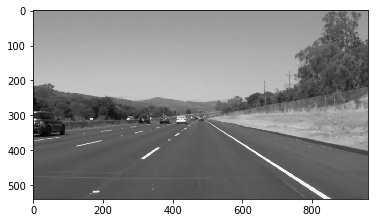

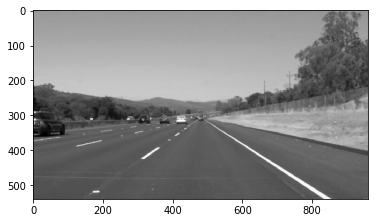

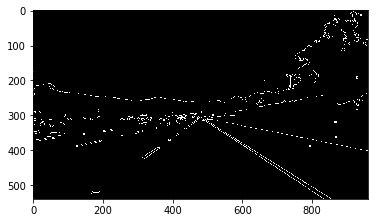

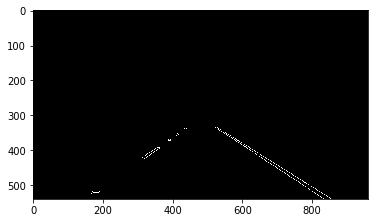

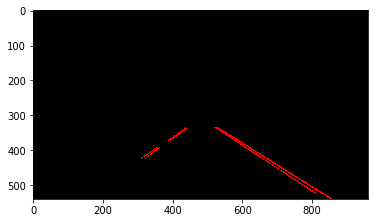

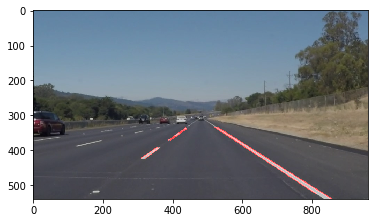

In [4]:
img = "solidWhiteRight.jpg"
frame = mpimg.imread("test_images/"+img)
#f = lane_line_detection(frame,full_extent=False)
gray_img = grayscale(frame) # Applies the Grayscale transform
mpimg.imsave("test_images_output/"+"grayscale_"+img,gray_img,cmap='gray')
plt.imshow(gray_img,cmap='gray')
plt.show()
blur_img = gaussian_blur(gray_img, param["blur_kernel"]) # Applies a Gaussian Noise kernel
mpimg.imsave("test_images_output/"+"gaussian_blur_"+img,blur_img,cmap='gray')
plt.imshow(blur_img,cmap='gray')
plt.show()
edges_img = canny(blur_img,param["canny_low_thr"],param["canny_high_thr"]) #Applies the Canny transform
mpimg.imsave("test_images_output/"+"canny_"+img,edges_img,cmap='gray')
plt.imshow(edges_img,cmap='gray')
plt.show()
left_masked_img = region_of_interest(edges_img,np.array([[(edges_img.shape[1]*param["lx1"],edges_img.shape[0]*param["ymax"]),\
                                                         (edges_img.shape[1]*param["lx2"],edges_img.shape[0]*param["ymin"]),\
                                                         (edges_img.shape[1]*param["lx3"],edges_img.shape[0]*param["ymin"]),\
                                                         (edges_img.shape[1]*param["lx4"],edges_img.shape[0]*param["ymax"])]],\
                                                       dtype=np.int32)) # Applies an image mask
right_masked_img = region_of_interest(edges_img,np.array([[(edges_img.shape[1]*param["rx1"],edges_img.shape[0]*param["ymax"]),\
                                                         (edges_img.shape[1]*param["rx2"],edges_img.shape[0]*param["ymin"]),\
                                                         (edges_img.shape[1]*param["rx3"],edges_img.shape[0]*param["ymin"]),\
                                                         (edges_img.shape[1]*param["rx4"],edges_img.shape[0]*param["ymax"])]],\
                                                       dtype=np.int32)) # Applies an image mask
masked_img = cv2.bitwise_or(left_masked_img, right_masked_img)
mpimg.imsave("test_images_output/"+"masked_img_"+img,masked_img,cmap='gray')
plt.imshow(masked_img,cmap='gray')
plt.show()
line_img = hough_lines(masked_img, param["rho"], param["theta"]*(np.pi/180), param["threshold"], param["min_line_len"], param["max_line_gap"],full_extent=False)
mpimg.imsave("test_images_output/"+"hough_lines_"+img,line_img,cmap='gray')
plt.imshow(line_img,cmap='gray')
plt.show()
final_img = weighted_img(line_img,frame)
mpimg.imsave("test_images_output/"+"final_img_"+img,final_img)
plt.imshow(final_img)
plt.show()

## Test all the images

Test all the images on the `test_images/` folder. The result is saved on the `test_images_output/` folder. 


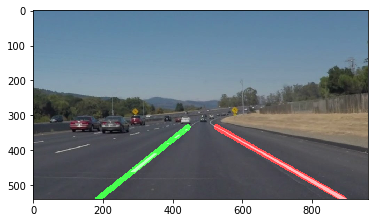

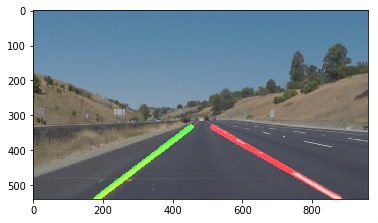

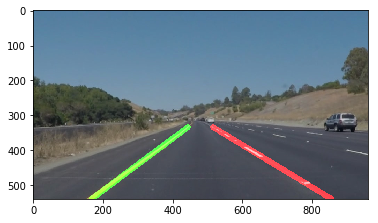

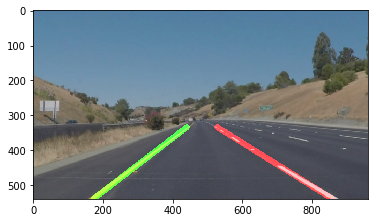

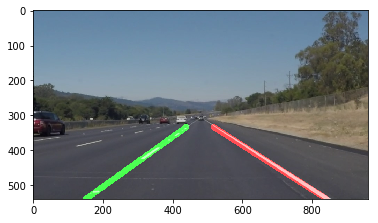

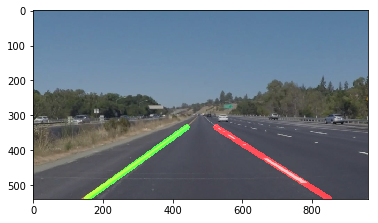

In [6]:
#Test the image load at the beginning of the file 'test_images/solidWhiteRight.jpg'

for img in os.listdir("test_images/"):
    img_input = mpimg.imread("test_images/" + img)
    img_output = lane_line_detection(img_input,full_extent=True)
    mpimg.imsave("test_images_output/"+img,img_output)
    plt.imshow(img_output)
    plt.show()


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [14]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    result = lane_line_detection(image,full_extent=True)
    return result

Let's try the one with the solid white lane on the right first ...

In [8]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Imageio: 'ffmpeg.linux64' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg.linux64 (27.2 MB)
Downloading: 8192/28549024 bytes (0.0163840/28549024 bytes (0.6507904/28549024 bytes (1.8868352/28549024 bytes (3.01187840/28549024 bytes (4.2%1499136/28549024 bytes (5.3%1843200/28549024 bytes (6.5%2138112/28549024 bytes (7.5%2465792/28549024 bytes (8.6%2859008/28549024 bytes (10.03252224/28549024 bytes (11.43579904/28549024 bytes (12.53940352/28549024 bytes (13.84317184/28549024 bytes (15.14644864/28549024 bytes (16.34972544/28549024 bytes (17.45414912/28549024 bytes (19.05726208/28549024 bytes (20.16070272/28549024 bytes (21.36692864/28549024 bytes (23.47053312/28549024 bytes (24.77380992/28549024 bytes (25.97725056/28549024 bytes (27.17987200/28549024 bytes (28.08314880/28549024 bytes (29.18626176/28549024 bytes (30.28953856/28549024 bytes (31.49330688/28549024 bytes (32.79707520/28549024 bytes (34.

100%|█████████▉| 221/222 [00:07<00:00, 32.46it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 4.25 s, sys: 1.14 s, total: 5.39 s
Wall time: 8.52 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))


## Improve the draw_lines() function

The `draw_lines` function has been modified accordingly to average and/or extrapolate the line segments detected to map out the full extent of the lane lines. The new output draw a single, solid line over the left lane line (`GREEN`) and a single, solid line over the right lane line (`RED`). The lines start from the bottom of the image and extend out to the top of the region of interest (the two region of interest).

In [18]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:31<00:00, 21.91it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 17.4 s, sys: 4.21 s, total: 21.6 s
Wall time: 32.2 s


In [19]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [20]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:22<00:00, 11.21it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 11.4 s, sys: 2.72 s, total: 14.1 s
Wall time: 24.8 s


In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

## Identify potential shortcomings with your current pipeline


* The lines detected flip a little bit on the videos. As we are making the average/extrapolation of each frame the result slope is the calculus of the slopes detected on the frame. 
* The algorithm doen't work very well with spurious data so use techniques for roboust estimation like LS, MLS or RANSAC should be a good idea
* The line model used be the Hough transformation is very simple, so only straigh lines can be detected
* The ROI area is fixed, so it's not possible to adapt the lane line detection pipe line to different scenarios.


## Suggest possible improvements to your pipeline

* As the lines don't change to mucho between frames, take into account the previous slopes to calculate the new one.
* Include a roboust estimation algorithm like LS, MLS or RANSAC
* Use more complex models for the lines to be able to calculate lines in corners
* Adaptative ROI areas using different approaches to detect the lane lines in multiple scenarios (diferent roads),